# Causality Analysis of Crypto Data

 This script performs a comprehensive analysis of causal relationships between major
 cryptocurrencies using Granger causality tests. It includes pairwise, multivariate,
 and time-varying Granger causality analyses to uncover potential causal influences
 among cryptocurrencies.

## References:
* [Granger Causality (Wikipedia)](https://en.wikipedia.org/wiki/Granger_causality)
* [Granger Causality: A Review (Annual Reviews)](https://www.annualreviews.org/content/journals/10.1146/annurev-statistics-040120-010930)

## Goal:
* Determine causal relationships between BTC and other major crypto currencies
* Analyze the stability of these relationships over time

In [10]:
import glob
import os
# Import causality analysis tools
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns

# Add the project root to the python path
try:
    # This works when the script is run directly
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), "..", ".."))
except NameError:
    # This works when run in an interactive environment like Jupyter
    # Assumes the notebook is in notebooks/python or notebooks/jupyter
    project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis.granger_causality import GrangerCausalityAnalyzer
from src.analysis.time_varying_granger import (plot_tvgc_results,
                                               rolling_granger_causality,
                                               summarize_tvgc_results)

# Set style for better visualizations
sns.set_theme()
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [12, 6]

## Data Loading
First, let's load our data files containing the cryptocurrency data.

In [11]:


def load_all_crypto_data(data_dir=os.path.join(project_root, "data", "processed")):
    all_data = {}
    for file in glob.glob(os.path.join(data_dir, "*.parquet")):
        symbol = os.path.basename(file).split("_")[0]
        # Get symbol from filename
        print(f"Loading {file}...")
        df = pq.read_table(file).to_pandas()
        all_data[symbol] = df
    return all_data

 ## Load Cryptocurrency Data

  The data is expected to be in Parquet format, with each file named as
 `<symbol>_data.parquet`.
 The files should contain columns like `timestamp`, `open`, `high`, `low`, `close`,
 and `volume`.
 ### Note:
 Note that all data is downloaded from Binance using the binance API, and the
 src/data/downloader.py script.  This can be easily adapted to load different
 frequencies or different symbols

In [12]:
# Load the data

crypto_data = load_all_crypto_data()

Loading /home/nfiroo/dev/crypto/crypto_causality/data/processed/SOLUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading /home/nfiroo/dev/crypto/crypto_causality/data/processed/ADAUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading /home/nfiroo/dev/crypto/crypto_causality/data/processed/BTCUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading /home/nfiroo/dev/crypto/crypto_causality/data/processed/DOGEUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading /home/nfiroo/dev/crypto/crypto_causality/data/processed/XRPUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading /home/nfiroo/dev/crypto/crypto_causality/data/processed/BNBUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading /home/nfiroo/dev/crypto/crypto_causality/data/processed/ETHUSDT_1m_2024-01-01_2024-02-01.parquet...


In [13]:
# Calculate returns for each crypto
returns_data = {}
for symbol, df in crypto_data.items():
    returns = pd.DataFrame()
    returns["timestamp"] = df["timestamp"]
    returns["returns"] = np.log(df["close"].astype(float)).diff()
    returns_data[symbol] = returns

In [14]:
# Create a combined returns dataframe
combined_returns = pd.DataFrame()
for symbol, returns in returns_data.items():
    combined_returns[symbol] = returns["returns"]
combined_returns.index = list(returns_data.values())[0]["timestamp"]

## Pairwise Granger Causality
We will now perform pairwise Granger causality tests to identify potential causal
relationships between the cryptocurrencies.
Eseentially this is fitting a model of the form:
$$\Delta x_t = \alpha + \sum_{i=1}^{p} \beta_i \Delta x_{t-i} + \sum_{j=1}^{q} \gamma_j
\Delta y_{t-j} + \epsilon_t$$
where $x_t$ is the target variable (e.g., BTC returns) and $y_t$ is the predictor
variable and $p$ and $q$ are the lags for the target and predictor variables, chosen
using the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
The causality test checks if the coefficients $\gamma_j$ are significantly different
from zero, indicating that past values of $y_t$ help predict $x_t$.

In [15]:
# Initialize the analyzer
analyzer = GrangerCausalityAnalyzer(combined_returns, max_lags=10)

# Run pairwise causality analysis
pairwise_results = analyzer.run_pairwise_causality()

# Print summary of significant results
print("Pairwise Granger Causality Results (Significant at 5%):")
print(pairwise_results[pairwise_results["significant"]])

Pairwise Granger Causality Results (Significant at 5%):
       cause    effect    min_p_value  optimal_lag  significant
0    SOLUSDT   ADAUSDT   2.020423e-19            5         True
1    ADAUSDT   SOLUSDT   2.606874e-76            8         True
2    SOLUSDT   BTCUSDT   2.982025e-09           10         True
3    BTCUSDT   SOLUSDT   1.550221e-26           10         True
4    SOLUSDT  DOGEUSDT   3.778410e-36           10         True
5   DOGEUSDT   SOLUSDT  1.278802e-193            8         True
6    SOLUSDT   XRPUSDT   7.221960e-63            8         True
7    XRPUSDT   SOLUSDT  1.567474e-222            9         True
8    SOLUSDT   BNBUSDT   1.929234e-16           10         True
9    BNBUSDT   SOLUSDT   2.520596e-77            8         True
10   SOLUSDT   ETHUSDT   1.755186e-10           10         True
11   ETHUSDT   SOLUSDT   1.558438e-42            6         True
12   ADAUSDT   BTCUSDT   4.481836e-17           10         True
13   BTCUSDT   ADAUSDT   2.243102e-18           

### Visualization of Pairwise Granger Causality
A directed graph can help visualize the significant pairwise causal relationships.

In [16]:
def plot_causality_network(
    pairwise_results, title="Significant Granger Causal Relationships"
):
    G = nx.DiGraph()

    # Add nodes for all unique cryptocurrencies
    all_cryptos = pd.concat(
        [pairwise_results["cause"], pairwise_results["effect"]]
    ).unique()
    for crypto in all_cryptos:
        G.add_node(crypto)

    # Add edges for significant relationships
    significant_relationships = pairwise_results[pairwise_results["significant"]]
    for _, row in significant_relationships.iterrows():
        G.add_edge(row["cause"], row["effect"], weight=row["min_p_value"])

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.8)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=3000)

    # Draw edges
    nx.draw_networkx_edges(
        G, pos, arrowstyle="->", arrowsize=20, edge_color="gray", width=1.5
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    plt.title(title)
    plt.axis("off")
    plt.show()

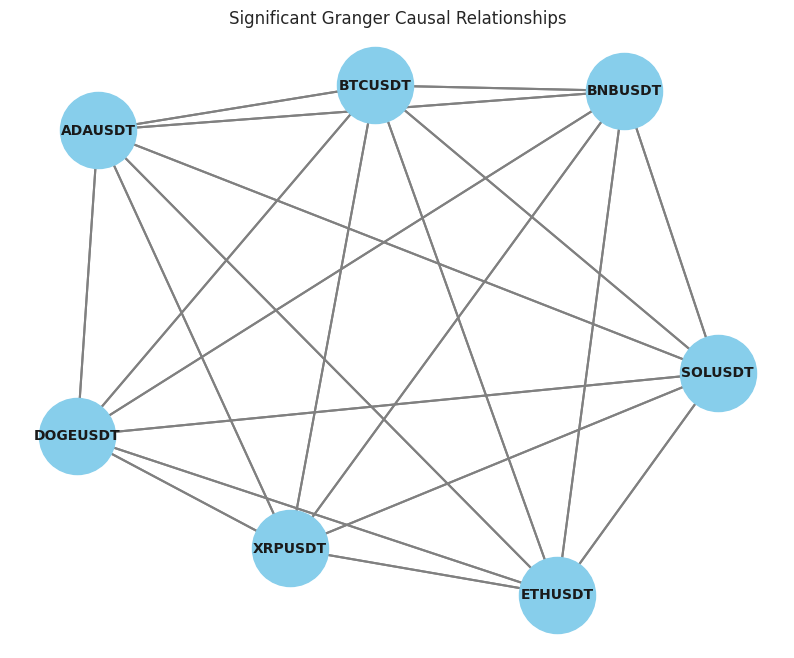

In [17]:
plot_causality_network(pairwise_results)

In [ ]:
# Get summary statistics
summary_stats = analyzer.get_summary_statistics()
print("\nCausality Summary Statistics:")

## Multivariate Granger Causality
Now, let's perform a multivariate Granger causality test to see which variables
Granger-cause Bitcoin (BTC) in a multivariate context.
For more details, see: [Multivariate Granger Causality (Wikipedia)](https://en.wikipedia.org/wiki/Granger_causality#Multivariate_analysis)
Rather than testing pairwise relationships, this approach considers all variables
simultaneously to determine their joint influence on the target variable, testing the
significance of the coefficients in a multivariate regression model.

In [ ]:
# Run multivariate causality analysis for BTC
target_crypto = "BTCUSDT"
test_stats, coef_pvals, optimal_lag = analyzer.run_multivariate_causality(
    target=target_crypto
)

print(
    f"\nMultivariate Granger Causality for {target_crypto} (Optimal Lag: {optimal_lag}):"
)

# Create a DataFrame for the results
multivariate_results = pd.DataFrame({"P-Value": test_stats})

### Visualization of Multivariate Granger Causality
A bar chart can effectively show the p-values of each variable's causal influence on the target.

In [ ]:
plt.figure(figsize=(10, 6))
multivariate_results.sort_values(by="P-Value", ascending=True).plot(
    kind="bar", ax=plt.gca()
)
plt.axhline(y=0.05, color="r", linestyle="--", label="5% Significance Level")
plt.title(f"Multivariate Granger Causality P-Values for {target_crypto}")
plt.xlabel("Causing Variable")
plt.ylabel("P-Value")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

## Time-Varying Granger Causality
Finally, let's analyze the time-varying Granger causality between Bitcoin (BTC) and a
less liquid coin, e.g., Solana (SOL)  to see if the relationship is stable over time.
For more details, see:
[Time-varying Granger Causality (Wikipedia)](https://en.wikipedia.org/wiki/Granger_causality#Time-varying_Granger_causality)
We note that this is a rolling window analysis, where we fit a Granger causality model
and is very much in the spirit of adaptive filtering, where the model is updated with
each observation (e.g., RLS, EWRLS, Kalman filter, etc). This is useful for
non-statioanry data, where the relationships between variables may change over time.

In [ ]:
# Define the pair to test
pair_to_test = ("BTCUSDT", "SOLUSDT")

# Run time-varying Granger causality analysis
tvgc_results = rolling_granger_causality(
    y=combined_returns[pair_to_test[1]],
    x=combined_returns[pair_to_test[0]],
    window_size=500,
)

# Plot the results
plot_tvgc_results({f"{pair_to_test[0]} -> {pair_to_test[1]}": tvgc_results})

# Summarize the results
summary = summarize_tvgc_results(
    {f"{pair_to_test[0]} -> {pair_to_test[1]}": tvgc_results}
)
print("\nTime-Varying Granger Causality Summary:")
print(summary)